## **Data Preprocessing**

In [ ]:
#Imports
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Use the cell below to read in the correct data file if running in Google Colab

In [ ]:
#Read in the dataset (must have it downloaded and in the same folder first)
from google.colab import files
uploaded = files.upload()

Saving wiki_movie_plots_deduped.csv to wiki_movie_plots_deduped.csv


In [ ]:
movies = pd.read_csv('wiki_movie_plots_deduped.csv')

In [ ]:
#Remove movies that don't originate from primarily English-speaking countries
origins = ['American','British','Australian','Canadian']
movies = movies[movies['Origin/Ethnicity'].isin(origins)]

In [ ]:
#Only keep movies from the 9 top genres
top_genres = ['western','comedy','drama','adventure','horror','thriller','musical','action','science fiction']
movies = movies[movies['Genre'].isin(top_genres)]

In [ ]:
#Only keep each movie's genre and plot description
movie_df = movies[['Genre','Plot']]

#### **Trimming plots**
The functions below outline the three different plot trimming approaches attempted - one that ignores stopwords, one that removes stopwords, and one that removes stopwords and names

In [ ]:
def trim_plot_leave_stopwords(plot):
  plot = plot.translate(str.maketrans('', '', string.punctuation))
  plot = plot.lower()
  remove_digits = str.maketrans('', '', string.digits)
  plot = plot.translate(remove_digits)
  plot = " ".join(plot.split())

  word_tokens = word_tokenize(plot)
  filtered_plot = [w for w in word_tokens]

  return filtered_plot

In [ ]:
def trim_plot(plot):
  plot = plot.translate(str.maketrans('', '', string.punctuation))
  plot = plot.lower()
  remove_digits = str.maketrans('', '', string.digits)
  plot = plot.translate(remove_digits)
  plot = " ".join(plot.split())

  stop_words = set(stopwords.words('english'))
 
  word_tokens = word_tokenize(plot)
  filtered_plot = [w for w in word_tokens if not w.lower() in stop_words]

  return filtered_plot

In [ ]:
def trim_plot_and_names(plot):
  plot = " ".join(plot.split())

  plot_split = plot.split(' ')
  for word_index in range(len(plot_split)):
    word = plot_split[word_index]
    if word[0].isupper() and word_index > 0 and plot_split[word_index-1][-1] != '.' and plot_split[word_index-1][-1] != '!' and plot_split[word_index-1][-1] != '?':
      plot = plot.replace(word,'')
  
  plot = plot.translate(str.maketrans('', '', string.punctuation))
  plot = plot.lower()
  remove_digits = str.maketrans('', '', string.digits)
  plot = plot.translate(remove_digits)
  

  stop_words = set(stopwords.words('english'))
 
  word_tokens = word_tokenize(plot)
  filtered_plot = [w for w in word_tokens if not w.lower() in stop_words]

  return filtered_plot

In [ ]:
movie_df = movie_df.reset_index().drop(['index'],axis=1)

In [ ]:
#make dataset with trimmed plots, leaving stopwords in
movie_df_with_stopwords = movie_df.copy()
movie_df_with_stopwords['Plot'] = movie_df_with_stopwords['Plot'].apply(lambda x: trim_plot_leave_stopwords(x))

In [ ]:
movie_df_stopwords_removed = movie_df.copy()
movie_df_stopwords_removed['Plot'] = movie_df_stopwords_removed['Plot'].apply(lambda x: trim_plot(x))

In [ ]:
#make dataset with trimmed plots, and names + stopwords removed
movie_df_names_removed = movie_df.copy()
movie_df_names_removed['WholePlot'] = movie_df_names_removed['Plot']
movie_df_names_removed['Plot'] = movie_df_names_removed['Plot'].apply(lambda x: trim_plot_and_names(x))

In [ ]:
movie_df_stopwords_removed.to_csv('trimmed_movies.csv') 
movie_df_with_stopwords.to_csv('trimmed_movies_with_stopwords.csv') 
movie_df_names_removed.to_csv('trimmed_movies_no_names.csv') 

Run the following cell if using Google Colab

In [ ]:
from google.colab import files
files.download("trimmed_movies.csv")
files.download("trimmed_movies_with_stopwords.csv")
files.download("trimmed_movies_no_names.csv")

From here on, these datasets will be used by reading in the data from these csvs we just created.

## **Exploratory Data Analysis**

In [ ]:
# Returns a two lists: one of the words, and one of their corresponding frequencies
# Arguments:
#    filt- Returns a filtered list (returns top 50 (default) words), set False for entire list
#    top - specifies how many of the top words you want to return (filt must be set to True)
#    ret_dict - returns a dictionary with words as the key, frequency as the value

def word_freqs(df, filt = True, top = 50, ret_dict = False):
    out = {}
    for plot in df["PlotPreProcessed"]:
        for word in plot:
            if word in out.keys():
                out[word] = out[word] + 1
            else:
                out[word] = 1
    out = {k: v for k, v in sorted(out.items(), key=lambda item: item[1], reverse = True)}
    if ret_dict:
        return out
    words = [x for x in out.keys()]
    freqs = [x for x in out.values()]
    if filt:
        words = words[:top]
        freqs = freqs[:top]
    return words, freqs

In [ ]:
# Draws a plot, used for exploratory purposes
# Arguments:
#     words- words you want to plot
#     freqs- the corresponding frequencies for these words
#     title- desired title for plot
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
def chart(words, freqs, title='title'):
    figure(figsize=(8,8), dpi=200)
    plt.bar(words,freqs)
    plt.xticks(rotation = 80)
    plt.title(title)
    plt.show()

In [ ]:
# Cuts a dictionary to a specified list, used for exploratory purposes
# Arguments:
#     d- the dictionary you want to cut
#     length - the length you want to dictionary to be
def slice_d(d, length):
    count = 0
    out = {}
    for x in d:
        if count == length:
            break
        out[x] = d[x]
        count+= 1
    return out

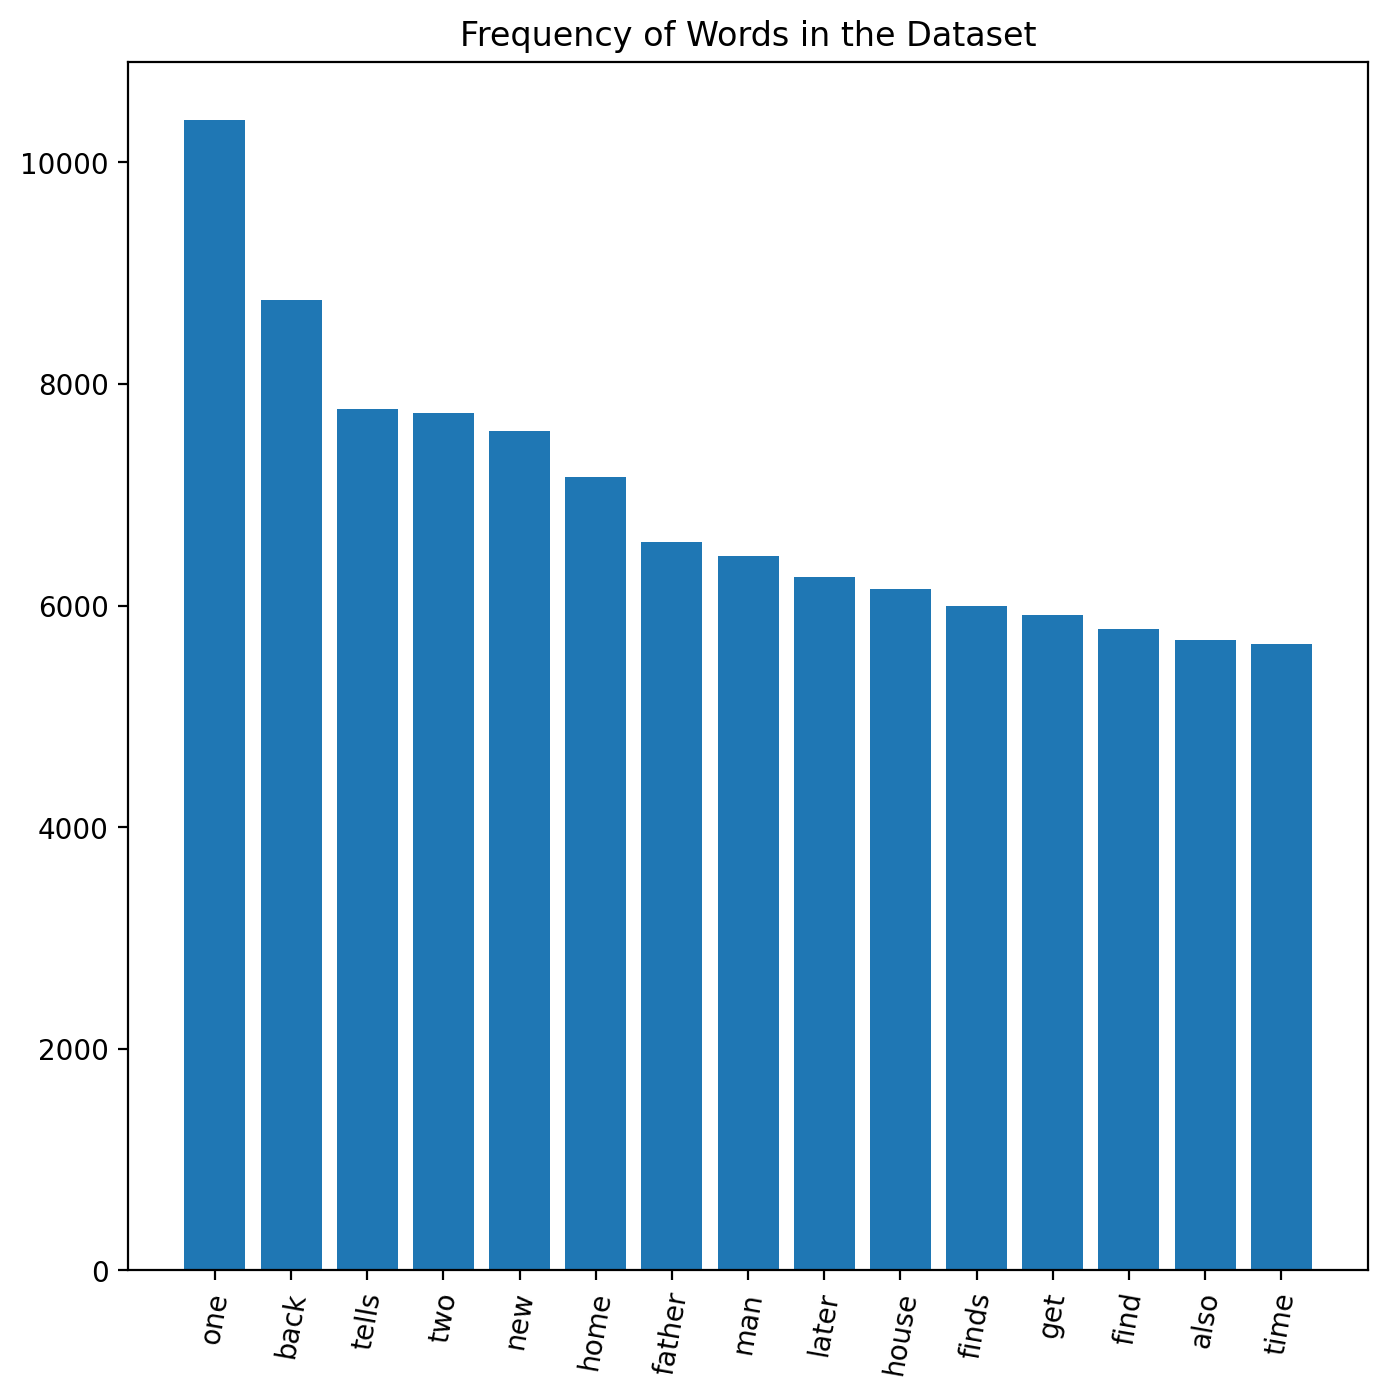

In [ ]:
#Use earlier trim_plot logic to create lists the our word_freqs function will parse
movie_df['PlotPreProcessed'] = movie_df['Plot'].apply(lambda x: trim_plot(x))
# returns a dictionary of the entire corpus with frequency as values
word_dict = word_freqs(movie_df, False, ret_dict = True)
# create list of top 50 words and their frequencies 
words, freqs = word_freqs(movie_df, top = 15)
chart(words, freqs, "Frequency of Words in the Dataset")

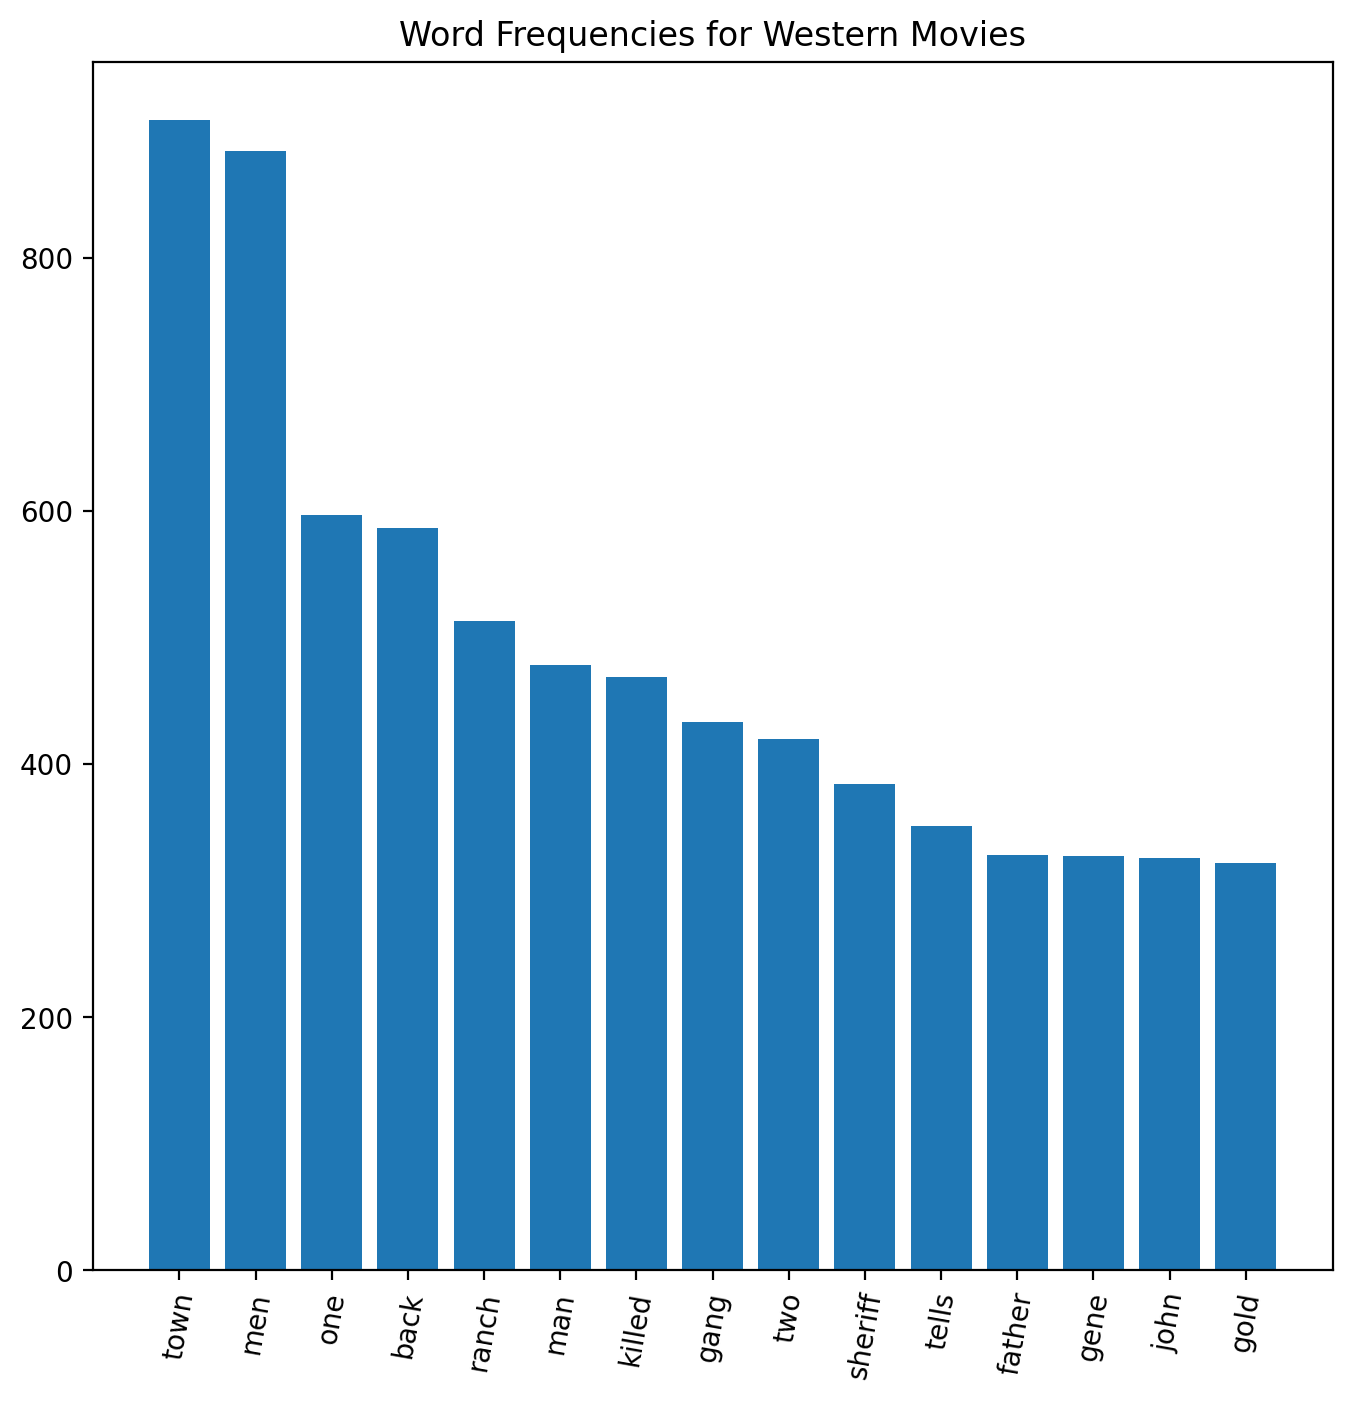

In [ ]:
#Filtering to western movies
wwords, wfreqs = word_freqs(movie_df[movie_df["Genre"] == "western"], top = 15)
chart(wwords,wfreqs, "Word Frequencies for Western Movies")

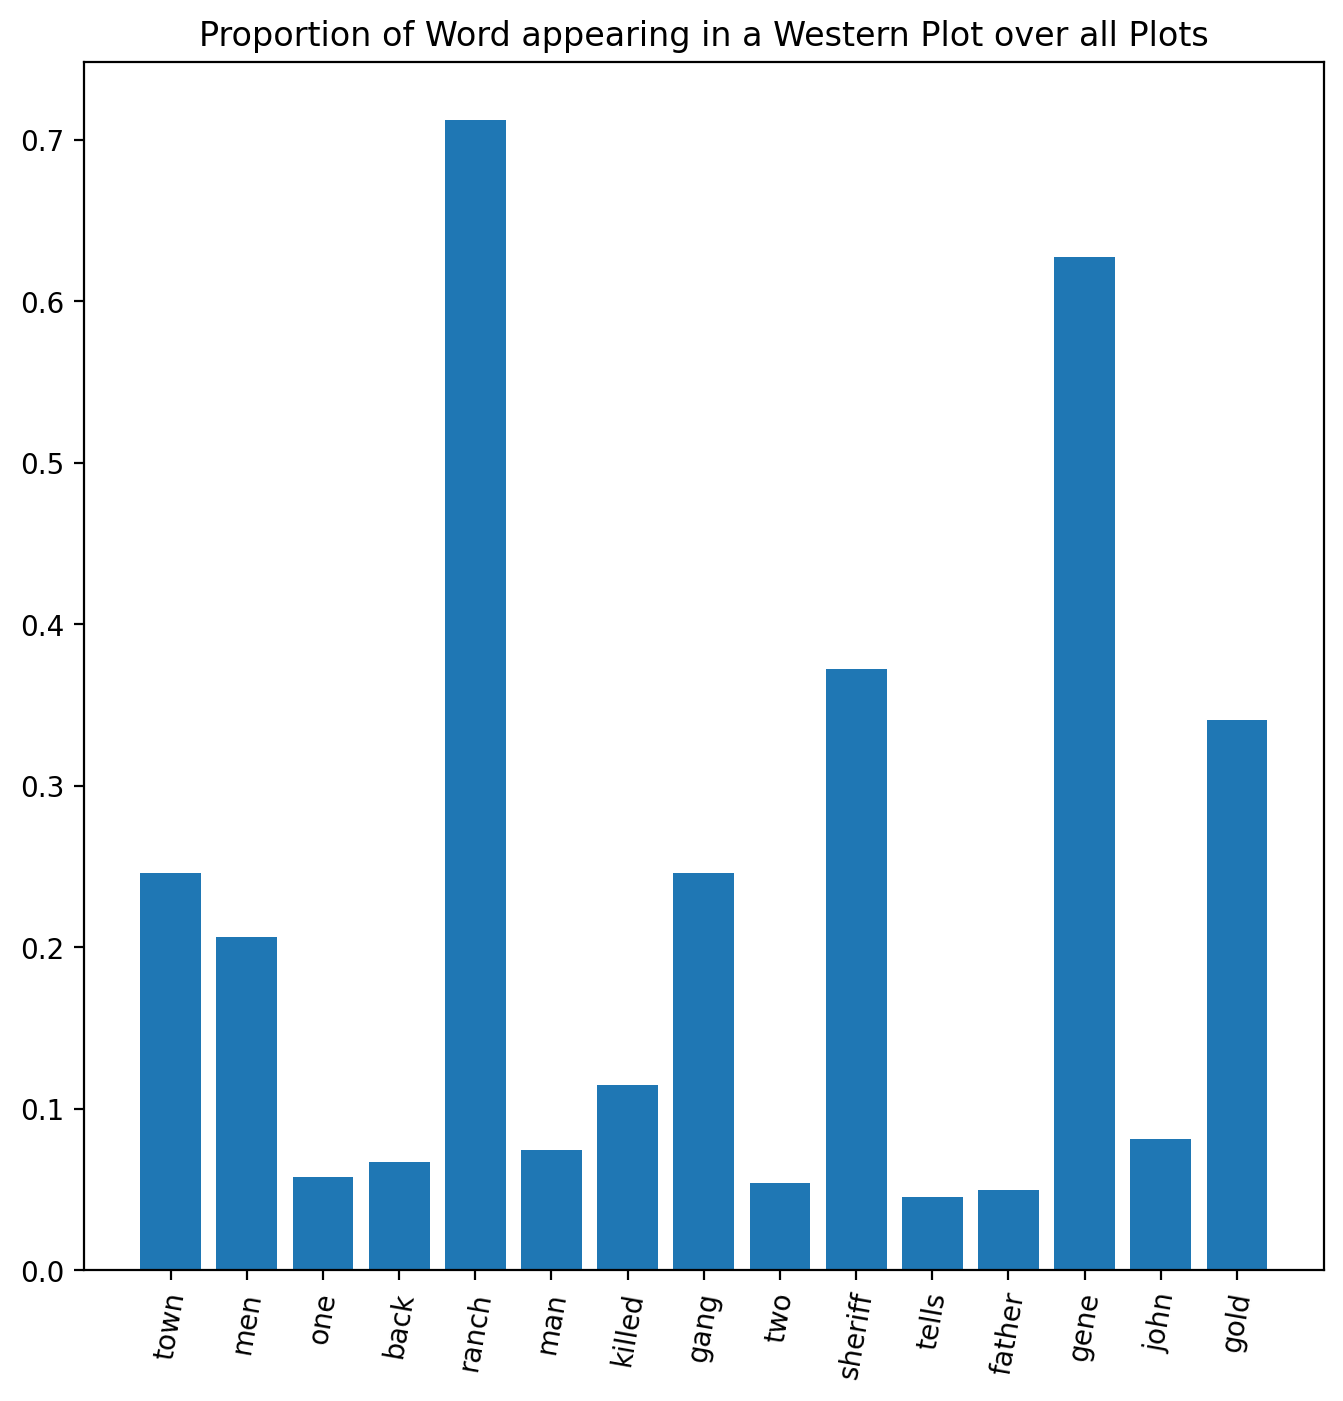

In [ ]:
# Graphs the proportion of the occurence of the word in western movies vs. all movies
w = []
p = []
for x, y in zip(wwords,wfreqs):
    w.append(x)
    p.append(y/word_dict[x])
chart(w, p, "Proportion of Word appearing in a Western Plot over all Plots")

In [ ]:
# **** NOTE: THIS CODE WAS USED TO GENERATE THE HEATMAP. IT TAKES FOREVER TO RUN, AND COMPLETELY UNNECESSARY. ****
out = pd.DataFrame(index=top_genres, columns=word_dict)
out = out.fillna(0)
western_dict = word_freqs(movie_df[movie_df["Genre"] == 'western'], filt = False, ret_dict = True)
comedy_dict = word_freqs(movie_df[movie_df["Genre"] == 'comedy'], filt = False, ret_dict = True)
drama_dict = word_freqs(movie_df[movie_df["Genre"] == 'drama'], filt = False, ret_dict = True)
adventure_dict = word_freqs(movie_df[movie_df["Genre"] == 'adventure'], filt = False, ret_dict = True)
horror_dict = word_freqs(movie_df[movie_df["Genre"] == 'horror'], filt = False, ret_dict = True)
thriller_dict = word_freqs(movie_df[movie_df["Genre"] == 'thriller'], filt = False, ret_dict = True)
musical_dict = word_freqs(movie_df[movie_df["Genre"] == 'musical'], filt = False, ret_dict = True)
action_dict = word_freqs(movie_df[movie_df["Genre"] == 'action'], filt = False, ret_dict = True)
scifi_dict = word_freqs(movie_df[movie_df["Genre"] == 'science fiction'], filt = False, ret_dict = True)
dicts = [western_dict, comedy_dict, drama_dict, adventure_dict, horror_dict, thriller_dict, musical_dict, action_dict, scifi_dict]
count = 0
for word, freq in word_dict.items():
    col = []
    for d in dicts:
        col.append(d.get(word, 0)/freq)
    out[word] = col
    count += 1
    if(count%1000 == 0):
        print(count)
wordlist = []
for genre in top_genres:
    words, freqs = word_freqs(movie_df[movie_df["Genre"] == genre], top=5)
    for word in words:
        wordlist.append(word)
temp = set(wordlist)
wordlist = list(temp)
a = out[wordlist]
plt.figure(figsize=(30, 30), dpi=400)
plt.imshow(a, cmap='gnuplot')
plt.yticks(range(len(a)), labels = a.index.values)
plt.xticks(range(len(a.columns)), labels = a.columns.values, rotation = 80)
plt.colorbar()
plt.show()

## **Naive Bayes**

Implement train_naive_bayes and test_naive_bayes

In [ ]:
def train_naive_bayes(D,C):
    #Get the total number of documents
    N_doc = 0
    for c in C:
        N_doc += len(D[c])
    
    #Get vocabulary and bigdoc of D
    entire_document_list = []
    for c in C:
        for entry in D[c]:
            for word in entry:
                entire_document_list.append(word)
    V = set(entire_document_list)
    
    #Get logprior and bigdoc
    logprior = {}
    bigdoc = {}
    count = {}
    log_likelihood = {}
    for c in C:
        N_c = len(D[c])
        
        logprior[c] = np.log(N_c/N_doc)
        bigdoc_c = []
        for entry in D[c]:
            for word in entry:
                bigdoc_c.append(word)
        bigdoc[c] = bigdoc_c
        
        sum_words_in_c = 0
        for word in V:
            count[(word,c)] = bigdoc[c].count(word)
            sum_words_in_c += (count[(word,c)] + 1)
        
        for word in V:
            log_likelihood[(word,c)] = np.log((count[(word,c)] + 1) / sum_words_in_c)
        
    return logprior,log_likelihood,V

In [ ]:
def test_naive_bayes(testdoc, logprior, loglikelihood, C, V):
    sum_list = {}
    for c in C:
        sum_list[c] = logprior[c]
        for word in testdoc:
            if word in V:
                sum_list[c] = sum_list[c] + loglikelihood[(word,c)]

    most_likely_c = list(C)[0]
    for c in sum_list:
        if sum_list[c] > sum_list[most_likely_c]:
            most_likely_c = c
    return most_likely_c

The modified version of test_naive_bayes below was implemented to return the 5 most influential words in classifying each movie as a particular genre

In [ ]:
def test_naive_bayes_modified(testdoc, logprior, loglikelihood, C, V):
    sum_list = {}
    for c in C:
        sum_list[c] = logprior[c]
        for word in testdoc:
            if word in V:
                sum_list[c] = sum_list[c] + loglikelihood[(word,c)]

    most_important_words = {}
    most_likely_c = list(C)[0]
    
    for c in sum_list:
        if sum_list[c] > sum_list[most_likely_c]:
            most_likely_c = c
    for word in testdoc:
        if word in V:
            other_genres = list(C)
            other_genres.remove(most_likely_c)
            most_important_words[word] = loglikelihood[(word,most_likely_c)] - sum([loglikelihood[(word,other_genre)] for other_genre in other_genres]) / (len(C) - 1)
        
    return most_likely_c,sorted(most_important_words,key=most_important_words.get,reverse=True)[:5]

### **Testing on original dataset**

In [ ]:
#Read in the dataset
df = pd.read_csv('trimmed_movies.csv')
df = df.drop(['Unnamed: 0'],axis=1)
df['Plot'] = df['Plot'].apply(lambda x: x.replace("[\'","").replace("\']","").split("\', \'"))

In [ ]:
#split data into training and testing set
train=df.sample(frac=0.7,random_state=69) #random state is a seed value
test=df.drop(train.index)

#Map each genre to its list of words
plot_mappings = {}
for genre in train['Genre'].unique():
    plot_mappings[genre] = train[train['Genre']==genre]['Plot']

Train the naive bayes classifier on the training dataset

In [ ]:
#WARNING - THIS CELL TAKES VERY LONG TO RUN
logprior, loglikelihood, V = train_naive_bayes(plot_mappings,plot_mappings.keys())

Display loglikelihoods associated with the word 'ranch' for each genre

In [ ]:
print("Log likelihood of word 'ranch' for each genre")
for genre in list(test['Genre'].unique()):
    print(genre + ': ' + str(loglikelihood[('ranch',genre)]))

Make genre predictions on the test data set and assess accuracy

In [ ]:
#Make predictions and print their accuracy
predictions = []
for i in range(len(test)):
    pred_genre = test_naive_bayes(test['Plot'].iloc[i],logprior,loglikelihood,plot_mappings.keys(),V)
    predictions.append(pred_genre)
print(accuracy_score(predictions,test['Genre']))  

Construct and visualize confusion matrix

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(test['Genre'],predictions,labels=list(test['Genre'].unique())),columns=list(test['Genre'].unique()),index=list(test['Genre'].unique()))
pd.concat(
    [pd.concat(
        [df_cm],
        keys=['Predicted Class'], axis=1)],
    keys=['Actual Class'])

Show most influential words for each genre using test_naive_bayes_modified

In [ ]:
predictions = []
word_counts = {'drama':{},'comedy':{},'horror':{},'thriller':{},'western':{},'action':{},'musical':{},'science fiction':{}}
for i in range(len(test)):
    pred_genre,impt_words = test_naive_bayes_modified(test['Plot'].iloc[i],logprior,loglikelihood,plot_mappings.keys(),V)
    for word in impt_words:
        word_counts_genre = word_counts.get(pred_genre,[])
        word_counts_genre[word] = word_counts_genre.get(word,0) + 1
    predictions.append(pred_genre)

In [ ]:
#Print top ten words for each genre
for genre in word_counts.keys():
    print(genre +':  '+ str(sorted(word_counts[genre], key=word_counts[genre].get, reverse=True)[:10]))

### **Testing on dataset with equal \# sampled from each genre**

Randomly sample 377 movies from every genre

In [ ]:
df_drama = df[df['Genre']=='drama'].sample(n = 377,random_state=55)
df_adventure = df[df['Genre']=='adventure'].sample(n = 377,random_state=55)
df_comedy = df[df['Genre']=='comedy'].sample(n = 377,random_state=55)
df_horror = df[df['Genre']=='horror'].sample(n = 377,random_state=55)
df_thriller = df[df['Genre']=='thriller'].sample(n = 377,random_state=55)
df_western = df[df['Genre']=='western'].sample(n = 377,random_state=55)
df_action = df[df['Genre']=='action'].sample(n = 377,random_state=55)
df_musical = df[df['Genre']=='musical'].sample(n = 377,random_state=55)
df_science_fiction = df[df['Genre']=='science fiction'].sample(n = 377,random_state=55)
equal_length_df = pd.concat([df_comedy,df_adventure,df_drama,df_horror,df_thriller,df_western,df_action,df_musical,df_science_fiction])

Construct training/test data sets, and map genres to their word groups

In [ ]:
train_equal = equal_length_df.sample(frac=.7)
test_equal = equal_length_df.drop(train_equal.index)

plot_mappings_equal = {}
for genre in train_equal['Genre'].unique():
    plot_mappings_equal[genre] = train_equal[train_equal['Genre']==genre]['Plot']

Train naive bayes on this dataset

In [ ]:
#WARNING - THIS CELL TAKES A LONG TIME TO RUN
logprior_equal, loglikelihood_equal, V_equal = train_naive_bayes(plot_mappings_equal,plot_mappings_equal.keys())

Make predictions and display their accuracy

In [ ]:
predictions = []
for i in range(len(test_equal)):
    pred_genre = test_naive_bayes(test_equal['Plot'].iloc[i],logprior_equal,loglikelihood_equal,plot_mappings_equal.keys(),V_equal)
    predictions.append(pred_genre)
print(accuracy_score(predictions,test_equal['Genre']))

In [ ]:
#Construct confusion matrix
df_cm = pd.DataFrame(confusion_matrix(test_equal['Genre'],predictions,labels=list(test_equal['Genre'].unique())),columns=list(test_equal['Genre'].unique()),index=list(test_equal['Genre'].unique()))
df_cm = df_cm.reindex(['comedy','adventure','drama','western','thriller','horror','musical','action','science fiction'])
df_cm = df_cm[['comedy','adventure','drama','western','thriller','horror','musical','action','science fiction']]
pd.concat(
    [pd.concat(
        [df_cm],
        keys=['Predicted Class'], axis=1)],
    keys=['Actual Class'])

Show most influential words for each genre using test_naive_bayes_modified

In [ ]:
predictions = []
word_counts = {'drama':{},'adventure':{},'comedy':{},'horror':{},'thriller':{},'western':{},'action':{},'musical':{},'science fiction':{}}
for i in range(len(test_equal)):
    pred_genre,impt_words = test_naive_bayes_modified(test_equal['Plot'].iloc[i],logprior_equal,loglikelihood_equal,plot_mappings_equal.keys(),V_equal)
    for word in impt_words:
        word_counts_genre = word_counts.get(pred_genre,[])
        word_counts_genre[word] = word_counts_genre.get(word,0) + 1
    predictions.append(pred_genre)

In [ ]:
#Print top ten words for each genre
for genre in word_counts.keys():
    print(genre +':  '+ str(sorted(word_counts[genre], key=word_counts[genre].get, reverse=True)[:10]))

### **Testing on dataset with names removed**

Read in the dataset, randomly sample equal numbers from each genre, and do train-test-split

In [ ]:
#Read in the dataset
df_no_names = pd.read_csv('trimmed_movies_no_names.csv')
df_no_names = df_no_names.drop(['Unnamed: 0'],axis=1)
df_no_names['Plot'] = df_no_names['Plot'].apply(lambda x: x.replace("[\'","").replace("\']","").split("\', \'"))

#Sample from genres
df_drama_no_names = df_no_names[df_no_names['Genre']=='drama'].sample(n = 377,random_state=55)
df_adventure_no_names = df_no_names[df_no_names['Genre']=='adventure'].sample(n=377,random_state=55)
df_comedy_no_names = df_no_names[df_no_names['Genre']=='comedy'].sample(n = 377,random_state=55)
df_horror_no_names = df_no_names[df_no_names['Genre']=='horror'].sample(n = 377,random_state=55)
df_thriller_no_names = df_no_names[df_no_names['Genre']=='thriller'].sample(n = 377,random_state=55)
df_western_no_names = df_no_names[df_no_names['Genre']=='western'].sample(n = 377,random_state=55)
df_action_no_names = df_no_names[df_no_names['Genre']=='action'].sample(n = 377,random_state=55)
df_musical_no_names = df_no_names[df_no_names['Genre']=='musical'].sample(n = 377,random_state=55)
df_science_fiction_no_names = df_no_names[df_no_names['Genre']=='science fiction'].sample(n = 377,random_state=55)
no_names_df = pd.concat([df_comedy_no_names,df_adventure_no_names,df_drama_no_names,df_horror_no_names,df_thriller_no_names,df_western_no_names,df_action_no_names,df_musical_no_names,df_science_fiction_no_names])

#Train test split
train_no_names=no_names_df.sample(frac=0.7,random_state=69)
test_no_names=no_names_df.drop(train_no_names.index)

In [ ]:
#Map each genre to its list of words
plot_mappings_no_names = {}
for genre in train_no_names['Genre'].unique():
    plot_mappings_no_names[genre] = train_no_names[train_no_names['Genre']==genre]['Plot']

Train naive bayes on this dataset

In [ ]:
#WARNING - THIS CELL TAKES A LONG TIME TO RUN
logprior_no_names, loglikelihood_no_names, V_no_names = train_naive_bayes(plot_mappings_no_names,plot_mappings_no_names.keys())

Make predictions and display accuracy

In [ ]:
predictions = []
for i in range(len(test_no_names)):
    pred_genre = test_naive_bayes(test_no_names['Plot'].iloc[i],logprior_no_names,loglikelihood_no_names,plot_mappings_no_names.keys(),V_no_names)
    predictions.append(pred_genre)
print(accuracy_score(predictions,test_no_names['Genre']))

In [ ]:
#Show confusion matrix
df_cm = pd.DataFrame(confusion_matrix(test_no_names['Genre'],predictions,labels=list(test_no_names['Genre'].unique())),columns=list(test_no_names['Genre'].unique()),index=list(test_no_names['Genre'].unique()))
df_cm = df_cm.reindex(['comedy','adventure','drama','western','thriller','horror','musical','action','science fiction'])
df_cm = df_cm[['comedy','adventure','drama','western','thriller','horror','musical','action','science fiction']]
pd.concat(
    [pd.concat(
        [df_cm],
        keys=['Predicted Class'], axis=1)],
    keys=['Actual Class'])

Show most influential words for each genre using test_naive_bayes_modified

In [ ]:
predictions = []
word_counts = {'drama':{},'adventure':{},'comedy':{},'horror':{},'thriller':{},'western':{},'action':{},'musical':{},'science fiction':{}}
for i in range(len(test_no_names)):
    pred_genre,impt_words = test_naive_bayes_modified(test_no_names['Plot'].iloc[i],logprior_no_names,loglikelihood_no_names,plot_mappings_no_names.keys(),V_no_names)
    for word in impt_words:
        word_counts_genre = word_counts.get(pred_genre,[])
        word_counts_genre[word] = word_counts_genre.get(word,0) + 1
    predictions.append(pred_genre)

In [ ]:
#Print top ten words for each genre
for genre in word_counts.keys():
    print(genre +':  '+ str(sorted(word_counts[genre], key=word_counts[genre].get, reverse=True)[:10]))

#### **Look at words most commonly used in correct vs incorrect classifications**

In [ ]:
predictions = []
word_counts_wrong = {'drama':{},'adventure':{},'comedy':{},'horror':{},'thriller':{},'western':{},'action':{},'musical':{},'science fiction':{}}
word_counts_correct = {'drama':{},'adventure':{},'comedy':{},'horror':{},'thriller':{},'western':{},'action':{},'musical':{},'science fiction':{}}
for i in range(len(test_no_names)):
    pred_genre,impt_words = test_naive_bayes_modified(test_no_names['Plot'].iloc[i],logprior_no_names,loglikelihood_no_names,plot_mappings_no_names.keys(),V_no_names)
    for word in impt_words:
        if pred_genre == test_no_names.iloc[i]['Genre']:
            word_counts_genre = word_counts_correct.get(pred_genre,[])
            word_counts_genre[word] = word_counts_genre.get(word,0) + 1
        else:
            word_counts_genre = word_counts_wrong.get(pred_genre,[])
            word_counts_genre[word] = word_counts_genre.get(word,0) + 1
    predictions.append(pred_genre)

In [ ]:
print('=====MOST INFLUENTIAL WORDS FOR INCORRECT CLASSIFICATIONS=====')
for genre in word_counts_wrong.keys():
    print(genre +':  '+ str(sorted(word_counts_wrong[genre], key=word_counts_wrong[genre].get, reverse=True)[:10]))
print('=====MOST INFLUENTIAL WORDS FOR CORRECT CLASSIFICATIONS=====')
for genre in word_counts_correct.keys():
    print(genre +':  '+ str(sorted(word_counts_correct[genre], key=word_counts_correct[genre].get, reverse=True)[:10]))

## **TF IDF**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Returns a balanced version of movie_df. Sample size chosen as 377 because this was the max number of samples for the smallest genre
def sample_df(df):
    df_drama = df[df['Genre']=='drama'].sample(n = 377)
    df_adventure = df[df['Genre']=='adventure'].sample(n = 377)
    df_comedy = df[df['Genre']=='comedy'].sample(n = 377)
    df_horror = df[df['Genre']=='horror'].sample(n = 377)
    df_thriller = df[df['Genre']=='thriller'].sample(n = 377)
    df_western = df[df['Genre']=='western'].sample(n = 377)
    df_action = df[df['Genre']=='action'].sample(n = 377)
    df_musical = df[df['Genre']=='musical'].sample(n = 377)
    df_science_fiction = df[df['Genre']=='science fiction'].sample(n = 377)
    equal_length_df = pd.concat([df_comedy,df_drama,df_adventure, df_horror,df_thriller,df_western,df_action,df_musical,df_science_fiction])
    return equal_length_df

In [ ]:
# Creates the vectorizer object and generates the feature matrix
# Note: movie_df has two representations of its plot
#   1. Plot is the paragraph version of the data. This is the form we want it for the code to execute properly
#   2. PlotPreProcessed is the list version of each plot. This was used mainly for exploratory purposes, it does not need to be referenced any more
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(movie_df["Plot"])
X

<12995x74349 sparse matrix of type '<class 'numpy.float64'>'
	with 2453476 stored elements in Compressed Sparse Row format>

In [ ]:
# Run MultinomialNB for the feature matrix. Don't expect a great score!
train_x, test_x, train_y, test_y = train_test_split(X,movie_df["Genre"], test_size=0.2)
nb = MultinomialNB()
nb.fit(train_x, train_y)
nb.score(test_x, test_y)

0.42400923432089266

In [ ]:
# Some example code used for tuning a linear svm model 
# The hyperparameter here being tuned is max_df
# can easily be set to min_df, max_features, or any other argument that TfidfVectorizer supports
# NOTE: This code only does one run per option! Can wrap in another for loop for more confident results
import numpy as np
testing_df = sample_df(movie_df_names_removed)
final_score = 0
z = 0
for y in np.arange(.1,.9,.01):
    # ugly printing of progress. can comment out if desired
    print(y)
    # This is where to change max_df to something else
    vectorizer = TfidfVectorizer(max_df = y)
    X = vectorizer.fit_transform(testing_df["WholePlot"])
    train_x, test_x, train_y, test_y = train_test_split(X,testing_df["Genre"])
    svm_model = svm.SVC(kernel = 'linear')
    svm_model.fit(train_x, train_y)
    score = svm_model.score(test_x, test_y)
    if score > final_score:
        final_score = score
        z = y
# print the best parameter with its score
print(f"maxdf set to {z} with score of {final_score}%")

0.1


KeyboardInterrupt: ignored

In [ ]:
# Code that will repeat an experiment, this is a more trustworthy accuracy result
scores = []
testing_df = sample_df(movie_df_names_removed)
for _ in range(5):
    vectorizer = TfidfVectorizer(max_df = 0.2)
    X = vectorizer.fit_transform(testing_df["WholePlot"])
    train_x, test_x, train_y, test_y = train_test_split(X,testing_df["Genre"])
    svm_model = svm.SVC(kernel = 'linear')
    svm_model.fit(train_x, train_y)
    scores.append(svm_model.score(test_x, test_y))
sum(scores)/len(scores)

0.5667844522968198

In [ ]:
# Create a confusion matrix for any desired fit. Can change the model below to anything. Just make sure that 'pred' is the set of predicted labels
vectorizer = TfidfVectorizer(max_df = 0.2)
X = vectorizer.fit_transform(testing_df["WholePlot"])
train_x, test_x, train_y, test_y = train_test_split(X,testing_df["Genre"])
svm_model = svm.SVC(kernel = 'linear')
svm_model.fit(train_x, train_y)
# maintain similar logic below if you change the above model!
pred = svm_model.predict(test_x)
pd.DataFrame(confusion_matrix(test_y, pred, labels=top_genres), index = top_genres, columns = top_genres)

,western,comedy,drama,adventure,horror,thriller,musical,action,science fiction
western,80,2,5,3,0,3,0,1,0
comedy,1,40,23,6,1,7,8,7,1
drama,0,19,45,9,5,8,7,4,0
adventure,2,5,12,54,1,3,3,5,0
horror,1,2,8,5,60,15,1,4,4
thriller,0,14,13,8,13,37,0,10,3
musical,2,18,18,7,0,0,52,1,0
action,0,1,2,15,3,9,0,53,0
science fiction,0,5,3,3,8,4,0,10,67


In [ ]:
# Kind of misc. code, this will output a dictionary with the entire corpus and the feature matrix value that each word receives.
idf = vectorizer.idf_
dictionary = dict(zip(vectorizer.get_feature_names(), idf))
{k: v for k, v in sorted(dictionary.items(), key=lambda item: item[1], reverse = True)}

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{'00am': 8.436617265234226,
 '012': 8.436617265234226,
 '03': 8.436617265234226,
 '033': 8.436617265234226,
 '04': 8.436617265234226,
 '05': 8.436617265234226,
 '05pm': 8.436617265234226,
 '07': 8.436617265234226,
 '09': 8.436617265234226,
 '1000th': 8.436617265234226,
 '100km': 8.436617265234226,
 '100th': 8.436617265234226,
 '1011': 8.436617265234226,
 '1101': 8.436617265234226,
 '111': 8.436617265234226,
 '112': 8.436617265234226,
 '1127': 8.436617265234226,
 '1138': 8.436617265234226,
 '114': 8.436617265234226,
 '117': 8.436617265234226,
 '119b': 8.436617265234226,
 '120': 8.436617265234226,
 '1200': 8.436617265234226,
 '121': 8.436617265234226,
 '1249': 8.436617265234226,
 '125': 8.436617265234226,
 '125th': 8.436617265234226,
 '127': 8.436617265234226,
 '128': 8.436617265234226,
 '1290': 8.436617265234226,
 '12m': 8.436617265234226,
 '1332': 8.436617265234226,
 '134': 8.436617265234226,
 '136': 8.436617265234226,
 '140': 8.436617265234226,
 '1401': 8.436617265234226,
 '1408': 8.4

In [ ]:
# This code will generate the 'class based' method
# In terms of code, it is equivalent to group all plots of the same genre together, 
#   since the vectorizer sees each row of final as a 'document'. In our case, each row
#   is a genre. So it's all good :)
final = pd.DataFrame(index=top_genres, columns=["WholePlot"])
final = final.fillna(0)
for genre in top_genres:
    combined = ""
    for plot in movie_df_names_removed[movie_df_names_removed["Genre"] == genre]["WholePlot"]:
        combined += plot
    final["WholePlot"][genre] = combined
final

,WholePlot
western,The film opens with two bandits breaking into ...
comedy,The film is about a family who move to the sub...
drama,On a beautiful summer day a father and mother ...
adventure,A white girl (Florence Lawrence) rejects a pro...
horror,White-haired Dr. Jekyll has secretly locked hi...
thriller,Zara (Aileen Pringle) is a gypsy rogue who joi...
musical,The first scene has a marching band playing Th...
action,"In World War I, American pilots Mal Andrews (C..."
science fiction,Shipwrecked traveler Edward Parker (Richard Ar...


In [ ]:
# Now, we can run the vectorizer on the new df to test the 'class based' approach
# Note the small change in the code. This is because we want to train on the 'class based' df that we created,
# but that df has lost all of the rows we care about in the process. Thus, we transform the relevant df after fitting
vectorizer = TfidfVectorizer()
vectorizer.fit(final["WholePlot"])
X = vectorizer.transform(movie_df_names_removed["WholePlot"])
train_x, test_x, train_y, test_y = train_test_split(X,movie_df_names_removed["Genre"])
svm_model = svm.SVC(kernel = 'linear')
svm_model.fit(train_x, train_y)
svm_model.score(test_x, test_y)

0.5964912280701754

## **Other Misc. Experimentation**

In [ ]:
#Imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import svm as sklearn_svm

In [ ]:
#Read in dataset
df_no_names = pd.read_csv('trimmed_movies_no_names.csv')
df_no_names = df_no_names.drop(['Unnamed: 0'],axis=1)
df_no_names['Plot'] = df_no_names['Plot'].apply(lambda x: x.replace("[\'","").replace("\']","").split("\', \'"))

#Convert plots to single strings instead of lists of words
df_idf = df_no_names.copy()
df_idf['Plot'] = df_idf['Plot'].apply(lambda x: " ".join(x))

### **Using tfidf with ngrams for svm**

Try using ngrams of length 1 & 2

In [ ]:
vectorizer_ngram = TfidfVectorizer(ngram_range=(1,2))
X_ngram = vectorizer_ngram.fit_transform(df_idf["Plot"])

In [ ]:
train_x_ngram, test_x_ngram, train_y_ngram, test_y_ngram = train_test_split(X_ngram,df_idf["Genre"])
svm_ngram = sklearn_svm.SVC()
svm_ngram.fit(train_x_ngram, train_y_ngram)
svm_ngram.score(test_x_ngram, test_y_ngram)

Try using ngrams of length 1, 2, & 3

In [ ]:
vectorizer_ngram = TfidfVectorizer(ngram_range=(1,3))
X_ngram = vectorizer_ngram.fit_transform(df_idf["Plot"])

In [ ]:
train_x_ngram, test_x_ngram, train_y_ngram, test_y_ngram = train_test_split(X_ngram,df_idf["Genre"])
svm_ngram = sklearn_svm.SVC()
svm_ngram.fit(train_x_ngram, train_y_ngram)
svm_ngram.score(test_x_ngram, test_y_ngram)

### **Using tfidf with ngrams for multinomialNB**

In [ ]:
vectorizer_ngram = TfidfVectorizer(ngram_range=(1,4))
X_ngram = vectorizer_ngram.fit_transform(df_idf["Plot"])

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(train_x_ngram, train_y_ngram)
clf.score(test_x_ngram, test_y_ngram)

### **Using tfidf for RandomForestClassifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(train_x, train_y)
y_pred = classifier.predict(test_x)
print(accuracy_score(test_y, y_pred))

**SKLearn Black Box Implementation**

In [ ]:
import pandas as pd
from sklearn import metrics
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

In [ ]:
df = pd.read_csv("filtered_movies.csv",index_col=0,)

df.reset_index(drop=False,inplace=True)
df.rename(mapper={'index':'ID'},axis=1,inplace=True)

X = df['Plot']
y = df['Genre']

print(df.shape)
df.head()

In [ ]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

# Custom Lemmatizer
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]
    
### Make the SMOTE Pipeline
smote_pipeline = make_pipeline(CountVectorizer(tokenizer=LemmaTokenizer()),
                         TfidfTransformer(),
                         SMOTE(n_jobs=-1,random_state=42),
                         SGDClassifier(n_jobs=-1,verbose=0,random_state=42)
                        )


In [ ]:
def pipeline_cv(splits, X, Y, pipeline):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    
    reports = []
    for train, test in kfold.split(X, Y):
        fit = pipeline.fit(X.iloc[train], Y.iloc[train])
        prediction = fit.predict(X.iloc[test])
        
        reports.append(
            pd.DataFrame(
                metrics.classification_report(
                    Y.iloc[test],prediction,output_dict=True
                )
            )
        )

    df_concat = pd.concat([x for x in reports])

    by_row_index = df_concat.groupby(df_concat.index)
    df_means = by_row_index.mean()

    return df_means



In [ ]:
# Pipeline testing
pipeline_cv(5,X,y,smote_pipeline)

In [ ]:
### Create scorer
scorer = metrics.make_scorer(metrics.f1_score, average = 'weighted')

In [ ]:
params = {
    'countvectorizer__ngram_range':[(1,2),(1,3)],
    'countvectorizer__max_df':np.linspace(.5,.7,5),
    'countvectorizer__min_df':[1,2,3,4],
    'tfidftransformer__use_idf':[True],
    'tfidftransformer__smooth_idf':[True],
    'sgdclassifier__alpha':np.linspace(.00005,.0002),
    'sgdclassifier__loss':['squared_hinge']
}

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true,predicted,classes):
    import itertools
    cm=confusion_matrix(true,predicted,labels=classes)
    
    fig = plt.figure(figsize=(15,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm,cmap=plt.cm.Blues)
    plt.title('Confusion matrix',fontdict={'size':20})
    fig.colorbar(cax)
    
    ax.set_xticklabels([''] + classes,fontdict={'size':14})
    ax.set_yticklabels([''] + classes,fontdict={'size':14})
    
    plt.xlabel('Predicted',fontdict={'size':14})
    plt.ylabel('True',fontdict={'size':14})
    
    plt.grid(b=None)
    fmt = 'd'

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             fontdict={'size':14,'weight':'heavy'})

In [ ]:
# No longer used due to SMOTE
def equalize_df(df):
    df_adventure = df[df['Genre']=='adventure'].sample(n = 377)
    df_drama = df[df['Genre']=='drama'].sample(n = 377)
    df_comedy = df[df['Genre']=='comedy'].sample(n = 377)
    df_horror = df[df['Genre']=='horror'].sample(n = 377)
    df_thriller = df[df['Genre']=='thriller'].sample(n = 377)
    df_western = df[df['Genre']=='western'].sample(n = 377)
    df_action = df[df['Genre']=='action'].sample(n = 377)
    df_musical = df[df['Genre']=='musical'].sample(n = 377)
    df_science_fiction = df[df['Genre']=='science fiction'].sample(n = 377)
    equal_length_df = pd.concat([df_adventure, df_comedy,df_drama,df_horror,df_thriller,df_western,df_action,df_musical,df_science_fiction])
    return equal_length_df

**Formal Case 1**

In [ ]:
# Filtered but unprocessed dataset being run through the entire pipeline

In [ ]:
filtered = pd.read_csv('filtered_movies.csv')
X = filtered['Plot']
y = filtered['Genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
pipeline_cv(5,X,y,random_search)
best_model = random_search.best_estimator_
best_model

In [ ]:
fit = best_model.fit(X_train,y_train)
y_pred = fit.predict(X_test)

report = pd.DataFrame(
    metrics.classification_report(y_test,y_pred,output_dict=True)
)
report

In [ ]:
classes = list(report.columns)[:-3]
plot_confusion_matrix(y_test,y_pred,classes)

**Formal Case 2**

In [ ]:
# Now, we will run the Stochastic Gradient Descent on the manually processed dataset created by our team
np_pipeline = make_pipeline(CountVectorizer(),
                         SGDClassifier(n_jobs=-1,verbose=0,random_state=42)
                        )

np_params = {
    'sgdclassifier__alpha':np.linspace(.00005,.0002),
    'sgdclassifier__loss':['squared_hinge']
}

np_random_search = RandomizedSearchCV(np_pipeline,np_params,cv=5,n_jobs=-1,scoring=scorer,verbose=0)

In [ ]:
trimmed = pd.read_csv('trimmed_movies.csv')

X = trimmed['Plot']
y = trimmed['Genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
pipeline_cv(5,X,y,np_random_search)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
best_model = np_random_search.best_estimator_
fit = best_model.fit(X_train,y_train)
y_pred = fit.predict(X_test)

report = pd.DataFrame(
    metrics.classification_report(y_test,y_pred,output_dict=True)
)
report

In [ ]:
classes = list(report.columns)[:-3]
plot_confusion_matrix(y_test,y_pred,classes)

**Formal Case 3**

In [ ]:
# Now running the full pipeline on the trimmed dataset
random_search = RandomizedSearchCV(smote_pipeline,params,cv=5,n_jobs=-1,scoring=scorer,verbose=0)
pipeline_cv(5,X,y,random_search)

In [ ]:
best_model = random_search.best_estimator_
fit = best_model.fit(X_train,y_train)
y_pred = fit.predict(X_test)

report = pd.DataFrame(
    metrics.classification_report(y_test,y_pred,output_dict=True)
)
report

In [ ]:
classes = list(report.columns)[:-3]
plot_confusion_matrix(y_test,y_pred,classes)

**Further experimentation**

In [ ]:
# Logistic Loss Function for SGD Classifier
log_params = {
    'countvectorizer__ngram_range':[(1,2),(1,3)],
    'countvectorizer__max_df':np.linspace(.5,.7,5),
    'countvectorizer__min_df':[1,2,3,4],
    'tfidftransformer__use_idf':[True],
    'tfidftransformer__smooth_idf':[True],
    'sgdclassifier__alpha':np.linspace(.00005,.0002),
    'sgdclassifier__loss':['log']
}

random_search = RandomizedSearchCV(smote_pipeline,log_params,cv=5,n_jobs=-1,scoring=scorer,verbose=0)
pipeline_cv(5,X,y,random_search)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
best_model = random_search.best_estimator_
fit = best_model.fit(X_train,y_train)
y_pred = fit.predict(X_test)

report = pd.DataFrame(
    metrics.classification_report(y_test,y_pred,output_dict=True)
)
report

In [ ]:
classes = list(report.columns)[:-3]
plot_confusion_matrix(y_test,y_pred,classes)

In [ ]:
# Full pipeline on full dataset
df = pd.read_csv("filtered_movies.csv",index_col=0,)

df.reset_index(drop=False,inplace=True)
df.rename(mapper={'index':'ID'},axis=1,inplace=True)

X = df['Plot']
y = df['Genre']

random_search = RandomizedSearchCV(smote_pipeline,params,cv=5,n_jobs=-1,scoring=scorer,verbose=0)

pipeline_cv(5,X,y,random_search)

In [ ]:
best_model = random_search.best_estimator_
best_model

In [ ]:
data_set = pd.read_csv('filtered_movies.csv',index_col=0)

X = data_set['Plot']
y = data_set['Genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

[data.sort_index(inplace=True) for data in [X_test,X_train,y_test,y_train]]

print(X_train.shape, y_train.shape, X_test.shape,y_test.shape)

In [ ]:
fit = best_model.fit(X_train,y_train)
y_pred = fit.predict(X_test)
report = pd.DataFrame(
    metrics.classification_report(y_test,y_pred,output_dict=True)
)
report

In [ ]:
classes = list(report.columns)[:-3]
plot_confusion_matrix(y_test,y_pred,classes)